#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from CompetingMethods import *
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import pandas as pd

## Comparing our TAVIE algorithm for Laplace location-scale family (Type I)

**Competing method: black-box variational inference (BBVI)**

For BBVI, we have three methods viz., 
* a vanilla BBVI algorithm using a diagonal covariance structure,
* a patience BBVI algorithm using a diagonal covariance structure, but it monitors the relative change in ELBO and if there is no change in the ELBO (change being more than the selected tolerance) for patience steps, the algorithm converges, and
* a full covariance BBVI algorithm which uses a full covariance structure and monitors the relative ELBO change with respect to the tolerance selected for patience number of steps in order to report convergence.

In [2]:
# TAVIE model initialization
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
tau2_true = 3
num_reps = 50

# Containers for metrics
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_BBVI_patience = np.zeros(num_reps)
mse_beta_BBVI_fullcov = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_tau2_BBVI = np.zeros(num_reps)
mse_tau2_BBVI_patience = np.zeros(num_reps)
mse_tau2_BBVI_fullcov = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)
time_BBVI_patience = np.zeros(num_reps)
time_BBVI_fullcov = np.zeros(num_reps)

# True beta vector
beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# prior choice for running BBVI_Laplace_fullcov()
Sigma_prior = np.eye(p + 1)
a = 0.05
b = 0.05

# Main loop with progress bar for TAVIE and BBVI results
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = np.random.laplace(size=n, scale=1/np.sqrt(tau2_true))
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # TAVIE estimator
    t0 = perf_counter()
    laplace_model.fit(X, y, verbose=False) # fitting the TAVIE model for laplace
    time_TAVIE[rep] = perf_counter() - t0
    beta_est, tau2_est = laplace_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est - tau2_true)**2
    
    # BBVI vanilla estimator
    t0 = perf_counter()
    res2 = BBVI_Laplace(X_bbvi, y)
    time_BBVI[rep] = perf_counter() - t0
    beta_est2 = res2['beta_mean']
    tau2_est2 = res2['tau2_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_BBVI[rep] = (tau2_est2 - tau2_true)**2

    # BBVI patience estimator
    t0 = perf_counter()
    res3 = BBVI_Laplace_patience(X_bbvi, y, tol=1e-5)
    time_BBVI_patience[rep] = perf_counter() - t0
    beta_est3 = res3['beta_mean']
    tau2_est3 = res3['tau2_mean']
    mse_beta_BBVI_patience[rep] = np.mean((beta_est3 - beta_true)**2)
    mse_tau2_BBVI_patience[rep] = (tau2_est3 - tau2_true)**2

    # BBVI full covariance estimator
    t0 = perf_counter()
    res4 = BBVI_Laplace_fullcov(X_bbvi, y, Sigma_prior = Sigma_prior, a = a, b = b, tol=1e-5)
    time_BBVI_fullcov[rep] = perf_counter() - t0
    beta_est4 = res4['beta_mean']
    tau2_est4 = res4['tau2_mean']
    mse_beta_BBVI_fullcov[rep] = np.mean((beta_est4 - beta_true)**2)
    mse_tau2_BBVI_fullcov[rep] = (tau2_est4 - tau2_true)**2

Repetitions:   0%|                                                                                                                                          | 0/50 [00:00<?, ?it/s]

Early stopping at iter 1949: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   2%|██▌                                                                                                                               | 1/50 [00:06<05:09,  6.33s/it]

Early stopping at iter 2749: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2410: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   4%|█████▏                                                                                                                            | 2/50 [00:12<05:08,  6.42s/it]

Early stopping at iter 3907: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3363: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   6%|███████▊                                                                                                                          | 3/50 [00:19<05:16,  6.74s/it]

Early stopping at iter 4060: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2083: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   8%|██████████▍                                                                                                                       | 4/50 [00:25<04:53,  6.39s/it]

Early stopping at iter 2973: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2354: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  10%|█████████████                                                                                                                     | 5/50 [00:32<04:48,  6.41s/it]

Early stopping at iter 3754: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2560: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  12%|███████████████▌                                                                                                                  | 6/50 [00:37<04:27,  6.08s/it]

Early stopping at iter 2197: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3284: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  14%|██████████████████▏                                                                                                               | 7/50 [00:43<04:12,  5.87s/it]

Early stopping at iter 1969: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1833: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  16%|████████████████████▊                                                                                                             | 8/50 [00:48<04:04,  5.83s/it]

Early stopping at iter 2923: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2311: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  18%|███████████████████████▍                                                                                                          | 9/50 [00:55<04:09,  6.08s/it]

Early stopping at iter 2418: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2872: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  20%|█████████████████████████▊                                                                                                       | 10/50 [01:02<04:09,  6.23s/it]

Early stopping at iter 2425: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2106: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  22%|████████████████████████████▍                                                                                                    | 11/50 [01:08<04:05,  6.30s/it]

Early stopping at iter 2670: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2414: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  24%|██████████████████████████████▉                                                                                                  | 12/50 [01:14<03:53,  6.14s/it]

Early stopping at iter 2010: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3039: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  26%|█████████████████████████████████▌                                                                                               | 13/50 [01:20<03:47,  6.14s/it]

Early stopping at iter 2126: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2493: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  28%|████████████████████████████████████                                                                                             | 14/50 [01:26<03:42,  6.18s/it]

Early stopping at iter 2692: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2719: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  30%|██████████████████████████████████████▋                                                                                          | 15/50 [01:32<03:36,  6.20s/it]

Early stopping at iter 2413: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2733: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  32%|█████████████████████████████████████████▎                                                                                       | 16/50 [01:38<03:28,  6.12s/it]

Early stopping at iter 2232: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3715: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  34%|███████████████████████████████████████████▊                                                                                     | 17/50 [01:45<03:24,  6.21s/it]

Early stopping at iter 2452: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2809: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  36%|██████████████████████████████████████████████▍                                                                                  | 18/50 [01:51<03:22,  6.33s/it]

Early stopping at iter 3177: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2978: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  38%|█████████████████████████████████████████████████                                                                                | 19/50 [01:58<03:21,  6.48s/it]

Early stopping at iter 3403: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2227: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  40%|███████████████████████████████████████████████████▌                                                                             | 20/50 [02:05<03:13,  6.47s/it]

Early stopping at iter 3117: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3080: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  42%|██████████████████████████████████████████████████████▏                                                                          | 21/50 [02:11<03:09,  6.53s/it]

Early stopping at iter 3151: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2412: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  44%|████████████████████████████████████████████████████████▊                                                                        | 22/50 [02:18<03:00,  6.43s/it]

Early stopping at iter 2941: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2432: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  46%|███████████████████████████████████████████████████████████▎                                                                     | 23/50 [02:23<02:48,  6.25s/it]

Early stopping at iter 2165: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1685: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  48%|█████████████████████████████████████████████████████████████▉                                                                   | 24/50 [02:29<02:38,  6.09s/it]

Early stopping at iter 2391: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2558: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  50%|████████████████████████████████████████████████████████████████▌                                                                | 25/50 [02:36<02:34,  6.19s/it]

Early stopping at iter 3127: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3149: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  52%|███████████████████████████████████████████████████████████████████                                                              | 26/50 [02:42<02:33,  6.40s/it]

Early stopping at iter 3443: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2261: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  54%|█████████████████████████████████████████████████████████████████████▋                                                           | 27/50 [02:49<02:25,  6.31s/it]

Early stopping at iter 2858: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 4063: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  56%|████████████████████████████████████████████████████████████████████████▏                                                        | 28/50 [02:55<02:18,  6.31s/it]

Early stopping at iter 2384: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2942: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 29/50 [03:00<02:08,  6.12s/it]

Early stopping at iter 1867: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2687: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 30/50 [03:07<02:02,  6.13s/it]

Early stopping at iter 2764: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2435: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 31/50 [03:13<01:59,  6.30s/it]

Early stopping at iter 3662: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3179: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 32/50 [03:20<01:56,  6.47s/it]

Early stopping at iter 3481: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1901: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 33/50 [03:27<01:49,  6.43s/it]

Early stopping at iter 3363: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3190: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 34/50 [03:32<01:39,  6.20s/it]

Early stopping at iter 1884: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2044: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 35/50 [03:39<01:37,  6.50s/it]

Early stopping at iter 4436: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3105: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 36/50 [03:46<01:30,  6.47s/it]

Early stopping at iter 2957: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2802: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 37/50 [03:53<01:25,  6.57s/it]

Early stopping at iter 3565: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3002: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 38/50 [03:59<01:17,  6.43s/it]

Early stopping at iter 2349: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2921: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/50 [04:05<01:11,  6.46s/it]

Early stopping at iter 3182: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2297: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 40/50 [04:11<01:03,  6.38s/it]

Early stopping at iter 2967: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2436: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 41/50 [04:17<00:56,  6.27s/it]

Early stopping at iter 2682: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1679: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/50 [04:24<00:49,  6.23s/it]

Early stopping at iter 3198: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2479: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 43/50 [04:30<00:43,  6.21s/it]

Early stopping at iter 2864: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2571: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 44/50 [04:37<00:38,  6.49s/it]

Early stopping at iter 4355: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1664: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [04:43<00:31,  6.29s/it]

Early stopping at iter 2691: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3539: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 46/50 [04:49<00:25,  6.30s/it]

Early stopping at iter 2602: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2073: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 47/50 [04:55<00:18,  6.16s/it]

Early stopping at iter 2751: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3028: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [05:01<00:12,  6.08s/it]

Early stopping at iter 2231: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2635: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [05:07<00:06,  6.26s/it]

Early stopping at iter 3673: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2610: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:13<00:00,  6.28s/it]

Early stopping at iter 2591: no ELBO gain ≥ 1e-05 for 500 iters.


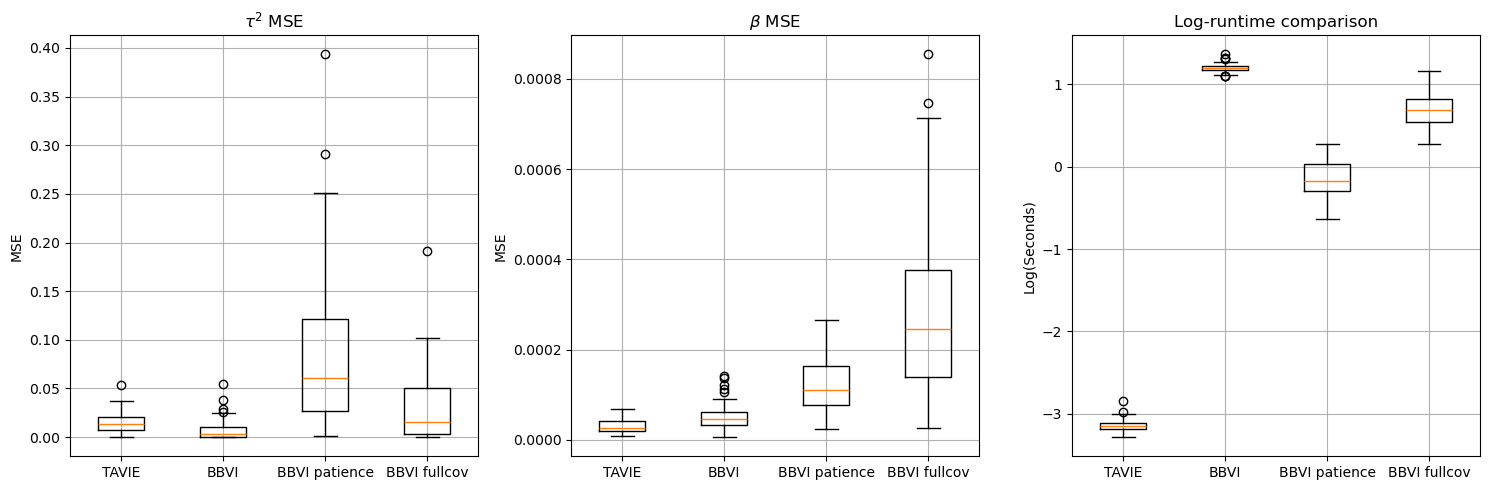

In [3]:
# Plotting results for TAVIE and BBVI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tau^2 MSE comparison
axes[0].boxplot([mse_tau2_TAVIE, mse_tau2_BBVI, mse_tau2_BBVI_patience, mse_tau2_BBVI_fullcov], 
                tick_labels=['TAVIE', 'BBVI', 'BBVI patience', 'BBVI fullcov'])
axes[0].set_title(r'$\tau^2$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([mse_beta_TAVIE, mse_beta_BBVI, mse_beta_BBVI_patience, mse_beta_BBVI_fullcov], 
                tick_labels=['TAVIE', 'BBVI', 'BBVI patience', 'BBVI fullcov'])
axes[1].set_title(r'$\beta$ MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_BBVI), np.log(time_BBVI_patience), np.log(time_BBVI_fullcov)], 
                tick_labels=['TAVIE', 'BBVI', 'BBVI patience', 'BBVI fullcov'])
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Student's-t location-scale family (Type I)

**Competing methods:**
* **black-box variational inference (BBVI)** and
* **mean-field variational inference (MFVI)**

The MFVI for Student's-t has been implemented in CompetingMethods/mfvi.py following Wand et al., 2011 <doi:10.1214/11-BA631>.

For BBVI, we have three methods viz., 
* a vanilla BBVI algorithm using a diagonal covariance structure,
* a patience BBVI algorithm using a diagonal covariance structure, but it monitors the relative change in ELBO and if there is no change in the ELBO (change being more than the selected tolerance) for patience steps, the algorithm converges, and
* a full covariance BBVI algorithm which uses a full covariance structure and monitors the relative ELBO change with respect to the tolerance selected for patience number of steps in order to report convergence.

In [6]:
# TAVIE model initialization
t_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# Experiment parameters
n = 10000
p = 5
nu_true = 2
tau2_true = 2
num_reps = 50

# Containers for metrics
mse_beta_MFVI = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_BBVI_patience = np.zeros(num_reps)
mse_beta_BBVI_fullcov = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_tau2_MFVI = np.zeros(num_reps)
mse_tau2_BBVI = np.zeros(num_reps)
mse_tau2_BBVI_patience = np.zeros(num_reps)
mse_tau2_BBVI_fullcov = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_MFVI = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)
time_BBVI_patience = np.zeros(num_reps)
time_BBVI_fullcov = np.zeros(num_reps)

# True beta vector
beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# prior choice for running BBVI_Laplace_fullcov()
Sigma_prior = np.eye(p + 1)
a0 = 0.05
b0 = 0.05

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = t.rvs(df=nu_true, size=n) / np.sqrt(tau2_true)
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # TAVIE estimator
    t0 = perf_counter()
    t_model.fit(X, y, nu=nu_true, verbose=False) # fitting the TAVIE model for Student's-t
    time_TAVIE[rep] = perf_counter() - t0
    beta_est, tau2_est = t_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est - tau2_true)**2
    

    # MFVI estimator
    t0 = perf_counter()
    beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                  mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                  A=2, B=2, nu_min=2.0, 
                                                  nu_max=20.0, tol=1e-6, verbose = False)
    time_MFVI = perf_counter() - t0
    beta_est2 = beta_hat
    tau2_est2 = 1/sigma_sq_hat
    mse_beta_MFVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_MFVI[rep] = (tau2_est2 - tau2_true)**2

    # BBVI vanilla estimator
    t0 = perf_counter()
    res2 = BBVI_student(X_bbvi, y, nu=nu_true)
    time_BBVI[rep] = perf_counter() - t0
    beta_est3 = res2['beta_mean']
    tau2_est3 = res2['tau2_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est3 - beta_true)**2)
    mse_tau2_BBVI[rep] = (tau2_est3 - tau2_true)**2

    # BBVI patience estimator
    t0 = perf_counter()
    res3 = BBVI_student_patience(X_bbvi, y, nu=nu_true, tol=1e-5)
    time_BBVI_patience[rep] = perf_counter() - t0
    beta_est4 = res3['beta_mean']
    tau2_est4 = res3['tau2_mean']
    mse_beta_BBVI_patience[rep] = np.mean((beta_est4 - beta_true)**2)
    mse_tau2_BBVI_patience[rep] = (tau2_est4 - tau2_true)**2

    # BBVI fullcov estimator
    t0 = perf_counter()
    res4 = BBVI_student_fullcov(X_bbvi, y, nu=nu_true, Sigma_prior=Sigma_prior, a0=a0, b0=b0, tol=1e-5)
    time_BBVI_fullcov[rep] = perf_counter() - t0
    beta_est5 = res4['beta_mean']
    tau2_est5 = res4['tau2_mean']
    mse_beta_BBVI_fullcov[rep] = np.mean((beta_est5 - beta_true)**2)
    mse_tau2_BBVI_fullcov[rep] = (tau2_est5 - tau2_true)**2

Repetitions:   0%|                                                                                                                                          | 0/50 [00:00<?, ?it/s]

Early stopping at iter 2240: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   2%|██▌                                                                                                                               | 1/50 [00:08<06:59,  8.56s/it]

Early stopping at iter 2933: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2168: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   4%|█████▏                                                                                                                            | 2/50 [00:16<06:47,  8.48s/it]

Early stopping at iter 2748: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2606: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   6%|███████▊                                                                                                                          | 3/50 [00:24<06:13,  7.95s/it]

Early stopping at iter 1419: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1741: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   8%|██████████▍                                                                                                                       | 4/50 [00:32<06:14,  8.15s/it]

Early stopping at iter 3171: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1356: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  10%|█████████████                                                                                                                     | 5/50 [00:39<05:51,  7.80s/it]

Early stopping at iter 1887: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3970: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  12%|███████████████▌                                                                                                                  | 6/50 [00:49<06:09,  8.41s/it]

Early stopping at iter 3282: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1440: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  14%|██████████████████▏                                                                                                               | 7/50 [00:57<05:50,  8.14s/it]

Early stopping at iter 2551: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2682: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  16%|████████████████████▊                                                                                                             | 8/50 [01:05<05:43,  8.18s/it]

Early stopping at iter 2375: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2525: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  18%|███████████████████████▍                                                                                                          | 9/50 [01:13<05:31,  8.09s/it]

Early stopping at iter 2043: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2264: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  20%|█████████████████████████▊                                                                                                       | 10/50 [01:21<05:30,  8.25s/it]

Early stopping at iter 2948: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1027: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  22%|████████████████████████████▍                                                                                                    | 11/50 [01:28<05:06,  7.85s/it]

Early stopping at iter 1938: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1717: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  24%|██████████████████████████████▉                                                                                                  | 12/50 [01:36<04:57,  7.84s/it]

Early stopping at iter 2567: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1371: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  26%|█████████████████████████████████▌                                                                                               | 13/50 [01:44<04:49,  7.83s/it]

Early stopping at iter 2664: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2450: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  28%|████████████████████████████████████                                                                                             | 14/50 [01:52<04:41,  7.81s/it]

Early stopping at iter 2003: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2914: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  30%|██████████████████████████████████████▋                                                                                          | 15/50 [01:59<04:29,  7.71s/it]

Early stopping at iter 1418: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1195: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  32%|█████████████████████████████████████████▎                                                                                       | 16/50 [02:07<04:23,  7.74s/it]

Early stopping at iter 2561: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1206: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  34%|███████████████████████████████████████████▊                                                                                     | 17/50 [02:14<04:06,  7.48s/it]

Early stopping at iter 1627: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2007: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  36%|██████████████████████████████████████████████▍                                                                                  | 18/50 [02:22<04:01,  7.56s/it]

Early stopping at iter 2319: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1824: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  38%|█████████████████████████████████████████████████                                                                                | 19/50 [02:28<03:45,  7.28s/it]

Early stopping at iter 1133: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 4155: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  40%|███████████████████████████████████████████████████▌                                                                             | 20/50 [02:37<03:53,  7.78s/it]

Early stopping at iter 2473: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2234: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  42%|██████████████████████████████████████████████████████▏                                                                          | 21/50 [02:45<03:49,  7.90s/it]

Early stopping at iter 2470: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1760: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  44%|████████████████████████████████████████████████████████▊                                                                        | 22/50 [02:53<03:42,  7.94s/it]

Early stopping at iter 2718: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2381: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  46%|███████████████████████████████████████████████████████████▎                                                                     | 23/50 [03:01<03:31,  7.84s/it]

Early stopping at iter 1829: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1879: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  48%|█████████████████████████████████████████████████████████████▉                                                                   | 24/50 [03:09<03:26,  7.93s/it]

Early stopping at iter 2700: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3710: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  50%|████████████████████████████████████████████████████████████████▌                                                                | 25/50 [03:18<03:23,  8.12s/it]

Early stopping at iter 2168: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1282: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  52%|███████████████████████████████████████████████████████████████████                                                              | 26/50 [03:25<03:12,  8.01s/it]

Early stopping at iter 2509: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2591: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  54%|█████████████████████████████████████████████████████████████████████▋                                                           | 27/50 [03:35<03:11,  8.35s/it]

Early stopping at iter 3401: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2856: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  56%|████████████████████████████████████████████████████████████████████████▏                                                        | 28/50 [03:43<03:03,  8.35s/it]

Early stopping at iter 2290: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1544: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 29/50 [03:50<02:46,  7.95s/it]

Early stopping at iter 1696: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3060: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 30/50 [03:58<02:42,  8.11s/it]

Early stopping at iter 2478: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1918: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 31/50 [04:06<02:33,  8.07s/it]

Early stopping at iter 2560: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1602: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 32/50 [04:14<02:24,  8.02s/it]

Early stopping at iter 2637: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1258: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 33/50 [04:24<02:22,  8.37s/it]

Early stopping at iter 4247: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2030: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 34/50 [04:32<02:12,  8.31s/it]

Early stopping at iter 2665: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2175: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 35/50 [04:40<02:03,  8.20s/it]

Early stopping at iter 2314: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1601: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 36/50 [04:47<01:52,  8.02s/it]

Early stopping at iter 2095: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1781: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 37/50 [04:54<01:41,  7.79s/it]

Early stopping at iter 1748: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2202: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 38/50 [05:02<01:32,  7.71s/it]

Early stopping at iter 1825: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1582: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/50 [05:10<01:25,  7.76s/it]

Early stopping at iter 2582: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2276: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 40/50 [05:17<01:16,  7.62s/it]

Early stopping at iter 1564: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2146: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 41/50 [05:26<01:11,  7.89s/it]

Early stopping at iter 2910: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2249: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/50 [05:33<01:02,  7.82s/it]

Early stopping at iter 2016: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1453: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 43/50 [05:40<00:53,  7.58s/it]

Early stopping at iter 1667: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2496: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 44/50 [05:48<00:45,  7.62s/it]

Early stopping at iter 1711: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1248: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [05:56<00:38,  7.78s/it]

Early stopping at iter 2485: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1709: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 46/50 [06:04<00:30,  7.67s/it]

Early stopping at iter 1469: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1341: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 47/50 [06:12<00:23,  7.72s/it]

Early stopping at iter 2417: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1256: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [06:19<00:15,  7.77s/it]

Early stopping at iter 2561: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2330: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [06:27<00:07,  7.63s/it]

Early stopping at iter 1409: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1700: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:34<00:00,  7.90s/it]

Early stopping at iter 2103: no ELBO gain ≥ 1e-05 for 500 iters.


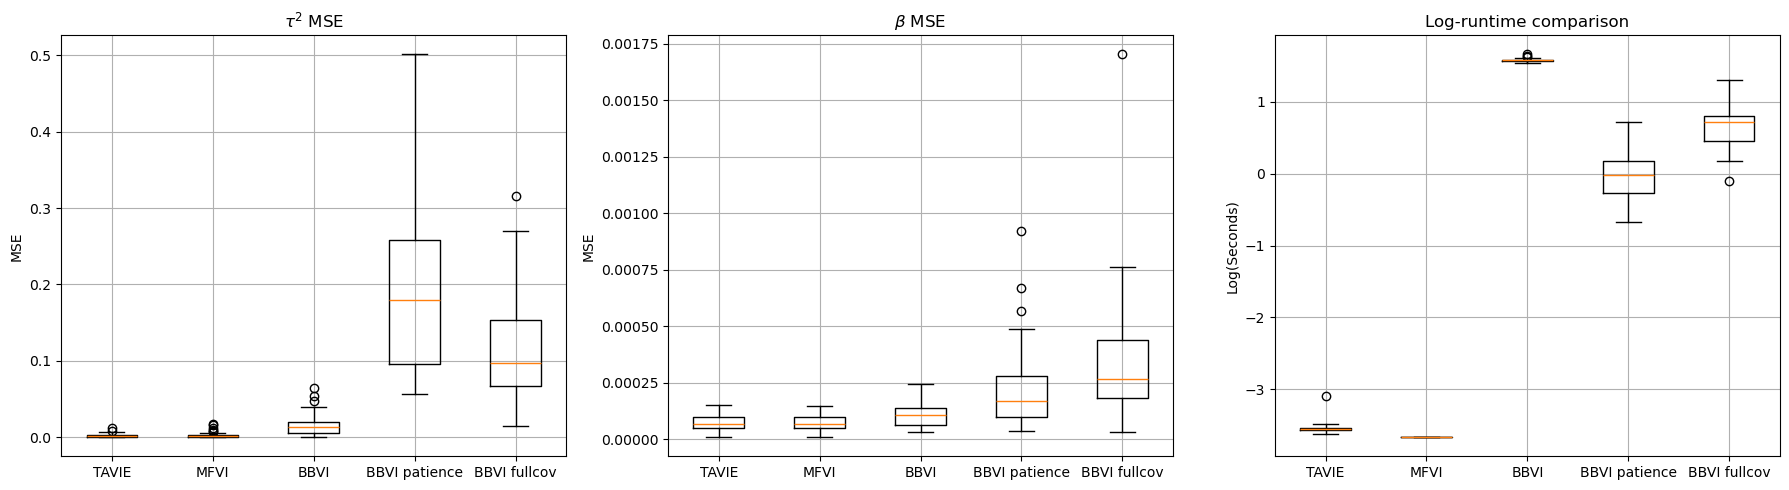

In [12]:
# Plotting results for TAVI, MFVI, and BBVI
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Tau^2 MSE comparison
axes[0].boxplot([mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_BBVI, mse_tau2_BBVI_patience, mse_tau2_BBVI_fullcov], 
                tick_labels=['TAVIE', 'MFVI', 'BBVI', 'BBVI patience', 'BBVI fullcov'])
axes[0].set_title(r'$\tau^2$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([mse_beta_TAVIE, mse_beta_MFVI, mse_beta_BBVI, mse_beta_BBVI_patience, mse_beta_BBVI_fullcov], 
                tick_labels=['TAVIE', 'MFVI', 'BBVI', 'BBVI patience', 'BBVI fullcov'])
axes[1].set_title(r'$\beta$ MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_MFVI), np.log(time_BBVI), np.log(time_BBVI_patience), np.log(time_BBVI_fullcov)], 
                tick_labels=['TAVIE', 'MFVI', 'BBVI', 'BBVI patience', 'BBVI fullcov'])
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Logistic family (Type II)

**Competing methods:**
* **black-box variational inference (BBVI)**,
* **mean-field variational inference (MFVI)**, and
* **stochastic variational inference (SVI)**

The MFVI (CAVI) and SVI for Bayesian logistic regression has been implemented in CompetingMethods/mfvi.py following Durante and Rigon, 2019 <https://doi.org/10.1214/19-STS712>.

For BBVI, we have three methods viz.,
* a patience BBVI algorithm using a diagonal covariance structure, but it monitors the relative change in ELBO and if there is no change in the ELBO (change being more than the selected tolerance) for patience steps, the algorithm converges, and
* a full covariance BBVI algorithm which uses a full covariance structure and monitors the relative ELBO change with respect to the tolerance selected for patience number of steps in order to report convergence.

In [4]:
# TAVIE model initialization
logit_model = TAVIE_type_II(family="binomial", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
num_reps = 100

# Containers for metrics
mse_beta_CAVI = np.zeros(num_reps)
mse_beta_SVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_BBVI_fullcov = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_CAVI = np.zeros(num_reps)
time_SVI = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)
time_BBVI_fullcov = np.zeros(num_reps)

prior = {
    'mu'   : np.zeros(p+1),
    'Sigma': np.eye(p+1)
}

beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
     
    linear_term = beta_true[0] + X @ beta_true[1:len(beta_true)]
    probs       = 1 / (1 + np.exp(-linear_term))
    y           = np.random.binomial(1, probs, size=n)

    # TAVIE estimator
    t0 = perf_counter()
    logit_model.fit(X, y, r=1, maxiter = 5000, verbose=False) # fitting the TAVIE model for logistic
    time_TAVIE[rep] = perf_counter() - t0
    beta_est1 = logit_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est1 - beta_true)**2)
    
    # CAVI estimator
    t0 = perf_counter()
    res2 = logit_cavi(X_bbvi, y, prior_params=prior,verbose=False)
    time_CAVI = perf_counter() - t0
    beta_est2 = res2['mu']
    mse_beta_CAVI[rep] = np.mean((beta_est2 - beta_true)**2)

    # SVI estimator
    t0 = perf_counter()
    res3 = logit_svi(
        X_bbvi,
        y,
        prior_params=prior,
        n_iter=10_000,
        tau=1.0,
        kappa=0.75,
        verbose=False,
        seed=123
    )
    time_SVI[rep] = perf_counter() - t0
    beta_est3 = res3['mu']
    mse_beta_SVI[rep] = np.mean((beta_est3 - beta_true)**2)

    # BBVI patience estimator
    t0 = perf_counter()
    res4 = BBVI_Logistic_patience(X_bbvi, y, tol=1e-5)
    time_BBVI[rep] = perf_counter() - t0
    beta_est4 = res4['beta_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est4 - beta_true)**2)

    # BBVI full covariance estimator
    t0 = perf_counter()
    res5 = BBVI_Logistic_fullcov(X_bbvi, y, Sigma_prior=prior['Sigma'], tol=1e-5)
    time_BBVI_fullcov[rep] = perf_counter() - t0
    beta_est5 = res5['beta_mean']
    mse_beta_BBVI_fullcov[rep] = np.mean((beta_est5 - beta_true)**2)

Repetitions:   0%|                                                                                                                                         | 0/100 [00:00<?, ?it/s]

Early stopping at iter 1877: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   1%|█▎                                                                                                                               | 1/100 [00:01<02:57,  1.79s/it]

Early stopping at iter 1419: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1930: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   2%|██▌                                                                                                                              | 2/100 [00:04<03:41,  2.26s/it]

Early stopping at iter 2596: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2168: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   3%|███▊                                                                                                                             | 3/100 [00:06<03:38,  2.25s/it]

Early stopping at iter 1933: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1914: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   4%|█████▏                                                                                                                           | 4/100 [00:08<03:37,  2.27s/it]

Early stopping at iter 2163: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1620: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   5%|██████▍                                                                                                                          | 5/100 [00:11<03:52,  2.45s/it]

Early stopping at iter 3068: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2432: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   6%|███████▋                                                                                                                         | 6/100 [00:13<03:37,  2.31s/it]

Early stopping at iter 1512: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2127: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   7%|█████████                                                                                                                        | 7/100 [00:16<03:47,  2.45s/it]

Early stopping at iter 2781: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2891: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   8%|██████████▎                                                                                                                      | 8/100 [00:19<04:07,  2.69s/it]

Early stopping at iter 3125: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1617: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   9%|███████████▌                                                                                                                     | 9/100 [00:21<03:49,  2.52s/it]

Early stopping at iter 2149: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2051: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  10%|████████████▊                                                                                                                   | 10/100 [00:23<03:32,  2.36s/it]

Early stopping at iter 1642: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1756: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  11%|██████████████                                                                                                                  | 11/100 [00:25<03:11,  2.15s/it]

Early stopping at iter 1266: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2160: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  12%|███████████████▎                                                                                                                | 12/100 [00:28<03:18,  2.26s/it]

Early stopping at iter 2389: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1680: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  13%|████████████████▋                                                                                                               | 13/100 [00:30<03:18,  2.28s/it]

Early stopping at iter 2327: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1537: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  14%|█████████████████▉                                                                                                              | 14/100 [00:32<03:09,  2.21s/it]

Early stopping at iter 2001: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1631: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  15%|███████████████████▏                                                                                                            | 15/100 [00:34<02:58,  2.10s/it]

Early stopping at iter 1670: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1455: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  16%|████████████████████▍                                                                                                           | 16/100 [00:35<02:47,  2.00s/it]

Early stopping at iter 1531: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1697: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  17%|█████████████████████▊                                                                                                          | 17/100 [00:38<02:47,  2.02s/it]

Early stopping at iter 1904: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2302: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  18%|███████████████████████                                                                                                         | 18/100 [00:40<02:44,  2.01s/it]

Early stopping at iter 1428: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2511: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  19%|████████████████████████▎                                                                                                       | 19/100 [00:42<02:53,  2.14s/it]

Early stopping at iter 2110: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2021: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  20%|█████████████████████████▌                                                                                                      | 20/100 [00:44<03:00,  2.25s/it]

Early stopping at iter 2454: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1866: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  21%|██████████████████████████▉                                                                                                     | 21/100 [00:47<02:53,  2.20s/it]

Early stopping at iter 1811: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2097: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  22%|████████████████████████████▏                                                                                                   | 22/100 [00:49<02:59,  2.30s/it]

Early stopping at iter 2464: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2081: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  23%|█████████████████████████████▍                                                                                                  | 23/100 [00:51<02:51,  2.22s/it]

Early stopping at iter 1691: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2414: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  24%|██████████████████████████████▋                                                                                                 | 24/100 [00:53<02:51,  2.25s/it]

Early stopping at iter 1952: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2712: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  25%|████████████████████████████████                                                                                                | 25/100 [00:56<03:00,  2.41s/it]

Early stopping at iter 2543: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2634: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  26%|█████████████████████████████████▎                                                                                              | 26/100 [00:59<03:01,  2.45s/it]

Early stopping at iter 2212: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2228: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  27%|██████████████████████████████████▌                                                                                             | 27/100 [01:01<02:45,  2.26s/it]

Early stopping at iter 1243: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2616: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  28%|███████████████████████████████████▊                                                                                            | 28/100 [01:03<02:55,  2.44s/it]

Early stopping at iter 2704: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1887: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  29%|█████████████████████████████████████                                                                                           | 29/100 [01:06<02:48,  2.37s/it]

Early stopping at iter 2069: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1939: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  30%|██████████████████████████████████████▍                                                                                         | 30/100 [01:07<02:34,  2.21s/it]

Early stopping at iter 1405: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1763: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  31%|███████████████████████████████████████▋                                                                                        | 31/100 [01:09<02:27,  2.14s/it]

Early stopping at iter 1755: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1791: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  32%|████████████████████████████████████████▉                                                                                       | 32/100 [01:12<02:25,  2.14s/it]

Early stopping at iter 2022: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2405: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  33%|██████████████████████████████████████████▏                                                                                     | 33/100 [01:14<02:32,  2.28s/it]

Early stopping at iter 2378: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1315: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  34%|███████████████████████████████████████████▌                                                                                    | 34/100 [01:17<02:32,  2.31s/it]

Early stopping at iter 2549: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2738: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  35%|████████████████████████████████████████████▊                                                                                   | 35/100 [01:19<02:29,  2.30s/it]

Early stopping at iter 1715: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2623: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  36%|██████████████████████████████████████████████                                                                                  | 36/100 [01:21<02:20,  2.20s/it]

Early stopping at iter 1246: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2078: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  37%|███████████████████████████████████████████████▎                                                                                | 37/100 [01:23<02:16,  2.17s/it]

Early stopping at iter 1708: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1816: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  38%|████████████████████████████████████████████████▋                                                                               | 38/100 [01:25<02:19,  2.26s/it]

Early stopping at iter 2395: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2456: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  39%|█████████████████████████████████████████████████▉                                                                              | 39/100 [01:28<02:29,  2.45s/it]

Early stopping at iter 2867: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1445: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  40%|███████████████████████████████████████████████████▏                                                                            | 40/100 [01:30<02:11,  2.19s/it]

Early stopping at iter 1203: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1840: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  41%|████████████████████████████████████████████████████▍                                                                           | 41/100 [01:32<02:07,  2.16s/it]

Early stopping at iter 1882: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2379: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  42%|█████████████████████████████████████████████████████▊                                                                          | 42/100 [01:34<02:04,  2.14s/it]

Early stopping at iter 1601: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1722: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  43%|███████████████████████████████████████████████████████                                                                         | 43/100 [01:37<02:09,  2.27s/it]

Early stopping at iter 2752: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2463: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  44%|████████████████████████████████████████████████████████▎                                                                       | 44/100 [01:39<02:14,  2.41s/it]

Early stopping at iter 2516: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1937: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  45%|█████████████████████████████████████████████████████████▌                                                                      | 45/100 [01:42<02:11,  2.40s/it]

Early stopping at iter 2243: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1665: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  46%|██████████████████████████████████████████████████████████▉                                                                     | 46/100 [01:43<01:58,  2.19s/it]

Early stopping at iter 1293: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2062: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  47%|████████████████████████████████████████████████████████████▏                                                                   | 47/100 [01:45<01:53,  2.14s/it]

Early stopping at iter 1659: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2195: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 48/100 [01:48<01:56,  2.24s/it]

Early stopping at iter 2270: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1749: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 49/100 [01:50<01:53,  2.22s/it]

Early stopping at iter 2005: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2120: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  50%|████████████████████████████████████████████████████████████████                                                                | 50/100 [01:52<01:49,  2.18s/it]

Early stopping at iter 1689: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2958: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 51/100 [01:55<01:50,  2.25s/it]

Early stopping at iter 1772: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1658: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 52/100 [01:57<01:45,  2.21s/it]

Early stopping at iter 1980: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1393: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 53/100 [01:59<01:41,  2.16s/it]

Early stopping at iter 1993: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2070: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  54%|█████████████████████████████████████████████████████████████████████                                                           | 54/100 [02:01<01:42,  2.22s/it]

Early stopping at iter 2131: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2367: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 55/100 [02:03<01:36,  2.15s/it]

Early stopping at iter 1354: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2221: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 56/100 [02:05<01:36,  2.18s/it]

Early stopping at iter 1947: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2113: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 57/100 [02:07<01:32,  2.15s/it]

Early stopping at iter 1794: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2154: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 58/100 [02:10<01:30,  2.14s/it]

Early stopping at iter 1703: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1487: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 59/100 [02:11<01:22,  2.01s/it]

Early stopping at iter 1410: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2211: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 60/100 [02:13<01:21,  2.03s/it]

Early stopping at iter 1659: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1900: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 61/100 [02:16<01:24,  2.15s/it]

Early stopping at iter 2286: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2101: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 62/100 [02:19<01:30,  2.39s/it]

Early stopping at iter 3009: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2529: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 63/100 [02:21<01:21,  2.21s/it]

Early stopping at iter 1029: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1838: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 64/100 [02:23<01:19,  2.22s/it]

Early stopping at iter 2043: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2797: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 65/100 [02:26<01:25,  2.45s/it]

Early stopping at iter 2738: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2238: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 66/100 [02:28<01:21,  2.39s/it]

Early stopping at iter 1968: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2867: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 67/100 [02:31<01:21,  2.48s/it]

Early stopping at iter 2276: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2030: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 68/100 [02:33<01:19,  2.50s/it]

Early stopping at iter 2456: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1871: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 69/100 [02:35<01:12,  2.34s/it]

Early stopping at iter 1641: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2250: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 70/100 [02:37<01:07,  2.24s/it]

Early stopping at iter 1507: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2476: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 71/100 [02:40<01:06,  2.29s/it]

Early stopping at iter 2094: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1960: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 72/100 [02:42<01:04,  2.31s/it]

Early stopping at iter 2208: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2356: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 73/100 [02:44<01:03,  2.35s/it]

Early stopping at iter 2115: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2004: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 74/100 [02:47<01:00,  2.32s/it]

Early stopping at iter 1961: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2304: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 75/100 [02:48<00:52,  2.12s/it]

Early stopping at iter 906: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1994: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 76/100 [02:51<00:52,  2.19s/it]

Early stopping at iter 2146: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1808: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 77/100 [02:53<00:49,  2.13s/it]

Early stopping at iter 1724: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2419: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 78/100 [02:55<00:47,  2.14s/it]

Early stopping at iter 1644: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2610: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 79/100 [02:57<00:47,  2.26s/it]

Early stopping at iter 2141: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1968: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 80/100 [02:59<00:43,  2.16s/it]

Early stopping at iter 1546: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2515: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 81/100 [03:01<00:40,  2.13s/it]

Early stopping at iter 1421: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1646: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 82/100 [03:04<00:41,  2.30s/it]

Early stopping at iter 2871: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2247: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 83/100 [03:06<00:37,  2.19s/it]

Early stopping at iter 1382: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2137: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 84/100 [03:09<00:38,  2.40s/it]

Early stopping at iter 3004: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1980: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 85/100 [03:11<00:33,  2.23s/it]

Early stopping at iter 1258: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2955: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 86/100 [03:14<00:36,  2.62s/it]

Early stopping at iter 3091: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1904: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 87/100 [03:17<00:34,  2.62s/it]

Early stopping at iter 2412: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2595: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 88/100 [03:19<00:30,  2.54s/it]

Early stopping at iter 1665: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1414: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 89/100 [03:21<00:25,  2.34s/it]

Early stopping at iter 1621: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2198: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 90/100 [03:23<00:21,  2.18s/it]

Early stopping at iter 1123: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2763: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 91/100 [03:26<00:21,  2.42s/it]

Early stopping at iter 2563: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1777: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [03:28<00:18,  2.27s/it]

Early stopping at iter 1475: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1688: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [03:30<00:16,  2.30s/it]

Early stopping at iter 2285: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1777: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 94/100 [03:32<00:13,  2.21s/it]

Early stopping at iter 1641: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1999: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 95/100 [03:35<00:11,  2.24s/it]

Early stopping at iter 2030: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1583: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [03:36<00:08,  2.16s/it]

Early stopping at iter 1743: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1477: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [03:38<00:06,  2.01s/it]

Early stopping at iter 1326: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1670: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [03:40<00:03,  1.88s/it]

Early stopping at iter 1029: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1736: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [03:42<00:01,  1.89s/it]

Early stopping at iter 1578: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2273: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.25s/it]

Early stopping at iter 2504: no ELBO gain ≥ 1e-05 for 500 iters.


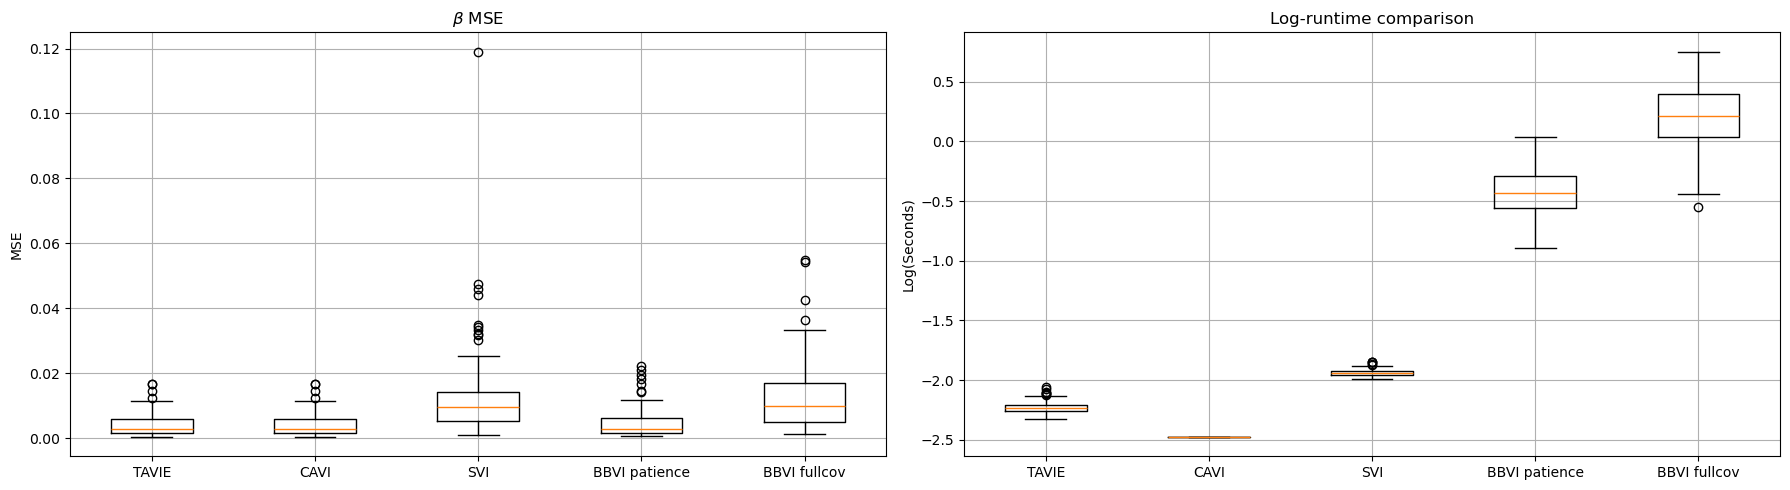

In [5]:
# Plotting results for TAVIE, CAVI, SVI, and BBVI
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Beta MSE comparison
axes[0].boxplot([mse_beta_TAVIE, mse_beta_CAVI, mse_beta_SVI, mse_beta_BBVI, mse_beta_BBVI_fullcov], 
                tick_labels=['TAVIE', 'CAVI', 'SVI', 'BBVI patience', 'BBVI fullcov'])
axes[0].set_title(r'$\beta$ MSE')
axes[0].set_ylabel('MSE')
#axes[0].set_ylim(0, 0.5)
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_CAVI), np.log(time_SVI), np.log(time_BBVI), np.log(time_BBVI_fullcov)], 
                tick_labels=['TAVIE', 'CAVI', 'SVI', 'BBVI patience', 'BBVI fullcov'])
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Negative-Binomial family (Type II)

**Competing method: black-box variational inference (BBVI)**

For BBVI, we have three methods viz.,
* a patience BBVI algorithm using a diagonal covariance structure, but it monitors the relative change in ELBO and if there is no change in the ELBO (change being more than the selected tolerance) for patience steps, the algorithm converges, and
* a full covariance BBVI algorithm which uses a full covariance structure and monitors the relative ELBO change with respect to the tolerance selected for patience number of steps in order to report convergence.

In [3]:
# TAVIE model initialization
negbin_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# Experiment parameters
n = 10000
p = 10
r = 20
num_reps = 50

# Containers for metrics
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_BBVI_fullcov = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)
time_BBVI_fullcov = np.zeros(num_reps)

beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Sigma_prior for running BBVI_NegBin_fullcov()
Sigma_prior = np.eye(p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)]
    probs = 1 / (1 + np.exp(-linear_term))
    y = np.random.negative_binomial(r, probs, size=n)

    # TAVIE estimator
    t0 = perf_counter()
    negbin_model.fit(X, y, r=r, maxiter = 20000, verbose=False) # Fitting the TAVIE model for Negative-Binomial
    time_TAVIE[rep] = perf_counter() - t0
    beta_est1 = negbin_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est1 - beta_true)**2)
    

    # BBVI patience estimator
    t0 = perf_counter()
    res2 = BBVI_NegBin_patience(X_bbvi, y, r=r, tol=1e-5)
    time_BBVI[rep] = perf_counter() - t0
    beta_est2 = res2['beta_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est2 - beta_true)**2)

    # BBVI full covariance estimator
    t0 = perf_counter()
    res3 = BBVI_NegBin_fullcov(X_bbvi, y, r=r, Sigma_prior=Sigma_prior, tol=1e-5)
    time_BBVI_fullcov[rep] = perf_counter() - t0
    beta_est3 = res3['beta_mean']
    mse_beta_BBVI_fullcov[rep] = np.mean((beta_est3 - beta_true)**2)

Repetitions:   0%|                                                                                                                                          | 0/50 [00:00<?, ?it/s]

Early stopping at iter 741: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   2%|██▌                                                                                                                               | 1/50 [00:01<01:12,  1.48s/it]

Early stopping at iter 878: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2759: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   4%|█████▏                                                                                                                            | 2/50 [00:05<02:17,  2.86s/it]

Early stopping at iter 3519: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2421: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   6%|███████▊                                                                                                                          | 3/50 [00:08<02:24,  3.07s/it]

Early stopping at iter 3421: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2644: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:   8%|██████████▍                                                                                                                       | 4/50 [00:10<02:00,  2.62s/it]

Early stopping at iter 997: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 4637: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  10%|█████████████                                                                                                                     | 5/50 [00:15<02:28,  3.31s/it]

Early stopping at iter 4205: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1894: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  12%|███████████████▌                                                                                                                  | 6/50 [00:20<02:55,  3.98s/it]

Early stopping at iter 6407: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3811: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  14%|██████████████████▏                                                                                                               | 7/50 [00:24<02:59,  4.17s/it]

Early stopping at iter 4548: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3459: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  16%|████████████████████▊                                                                                                             | 8/50 [00:27<02:28,  3.55s/it]

Early stopping at iter 745: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 4722: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  18%|███████████████████████▍                                                                                                          | 9/50 [00:29<02:11,  3.21s/it]

Early stopping at iter 850: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2086: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  20%|█████████████████████████▊                                                                                                       | 10/50 [00:31<01:48,  2.70s/it]

Early stopping at iter 804: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1927: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  22%|████████████████████████████▍                                                                                                    | 11/50 [00:34<01:47,  2.74s/it]

Early stopping at iter 2745: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2980: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  24%|██████████████████████████████▉                                                                                                  | 12/50 [00:36<01:41,  2.67s/it]

Early stopping at iter 1590: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1719: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  26%|█████████████████████████████████▌                                                                                               | 13/50 [00:38<01:30,  2.44s/it]

Early stopping at iter 1162: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1462: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  28%|████████████████████████████████████                                                                                             | 14/50 [00:39<01:17,  2.14s/it]

Early stopping at iter 862: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3005: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  30%|██████████████████████████████████████▋                                                                                          | 15/50 [00:43<01:30,  2.60s/it]

Early stopping at iter 3364: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2644: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  32%|█████████████████████████████████████████▎                                                                                       | 16/50 [00:45<01:21,  2.40s/it]

Early stopping at iter 1098: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3564: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  34%|███████████████████████████████████████████▊                                                                                     | 17/50 [00:48<01:22,  2.51s/it]

Early stopping at iter 1824: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1324: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  36%|██████████████████████████████████████████████▍                                                                                  | 18/50 [00:50<01:18,  2.46s/it]

Early stopping at iter 1774: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1780: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  38%|█████████████████████████████████████████████████                                                                                | 19/50 [00:52<01:07,  2.18s/it]

Early stopping at iter 774: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2232: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  40%|███████████████████████████████████████████████████▌                                                                             | 20/50 [00:54<01:02,  2.10s/it]

Early stopping at iter 1159: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2736: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  42%|██████████████████████████████████████████████████████▏                                                                          | 21/50 [00:56<01:04,  2.21s/it]

Early stopping at iter 1887: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2538: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  44%|████████████████████████████████████████████████████████▊                                                                        | 22/50 [01:00<01:16,  2.74s/it]

Early stopping at iter 4287: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1111: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  46%|███████████████████████████████████████████████████████████▎                                                                     | 23/50 [01:03<01:12,  2.70s/it]

Early stopping at iter 2755: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1180: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  48%|█████████████████████████████████████████████████████████████▉                                                                   | 24/50 [01:06<01:18,  3.03s/it]

Early stopping at iter 4413: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 890: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  50%|████████████████████████████████████████████████████████████████▌                                                                | 25/50 [01:16<02:07,  5.10s/it]

Early stopping at iter 698: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1690: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  52%|███████████████████████████████████████████████████████████████████                                                              | 26/50 [01:19<01:44,  4.34s/it]

Early stopping at iter 2470: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1475: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  54%|█████████████████████████████████████████████████████████████████████▋                                                           | 27/50 [01:21<01:21,  3.55s/it]

Early stopping at iter 823: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2738: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  56%|████████████████████████████████████████████████████████████████████████▏                                                        | 28/50 [01:24<01:14,  3.37s/it]

Early stopping at iter 2230: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2984: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 29/50 [01:26<01:02,  2.96s/it]

Early stopping at iter 1168: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3227: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 30/50 [01:28<00:54,  2.73s/it]

Early stopping at iter 968: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1218: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 31/50 [01:30<00:48,  2.55s/it]

Early stopping at iter 1545: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1093: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 32/50 [01:32<00:41,  2.29s/it]

Early stopping at iter 1653: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 642: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 33/50 [01:33<00:34,  2.01s/it]

Early stopping at iter 1209: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 851: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 34/50 [01:35<00:30,  1.94s/it]

Early stopping at iter 1744: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3531: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 35/50 [01:39<00:37,  2.51s/it]

Early stopping at iter 3575: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2083: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 36/50 [01:41<00:35,  2.52s/it]

Early stopping at iter 2419: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2000: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 37/50 [01:43<00:29,  2.27s/it]

Early stopping at iter 1070: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 651: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 38/50 [01:49<00:40,  3.40s/it]

Early stopping at iter 535: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 731: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 39/50 [01:51<00:31,  2.91s/it]

Early stopping at iter 1834: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2893: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 40/50 [01:57<00:40,  4.04s/it]

Early stopping at iter 8317: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1912: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 41/50 [01:59<00:29,  3.28s/it]

Early stopping at iter 900: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1287: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/50 [02:01<00:22,  2.83s/it]

Early stopping at iter 1082: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3174: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 43/50 [02:03<00:19,  2.85s/it]

Early stopping at iter 2452: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1241: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 44/50 [02:05<00:14,  2.49s/it]

Early stopping at iter 823: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 4759: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 45/50 [02:10<00:15,  3.11s/it]

Early stopping at iter 3911: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 3653: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 46/50 [02:13<00:12,  3.05s/it]

Early stopping at iter 2211: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 2404: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 47/50 [02:14<00:08,  2.69s/it]

Early stopping at iter 945: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1470: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48/50 [02:16<00:04,  2.34s/it]

Early stopping at iter 964: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 1707: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [02:19<00:02,  2.58s/it]

Early stopping at iter 3323: no ELBO gain ≥ 1e-05 for 500 iters.
Early stopping at iter 5350: no ELBO gain ≥ 1e-05 for 500 iters.


Repetitions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:22<00:00,  2.85s/it]

Early stopping at iter 926: no ELBO gain ≥ 1e-05 for 500 iters.


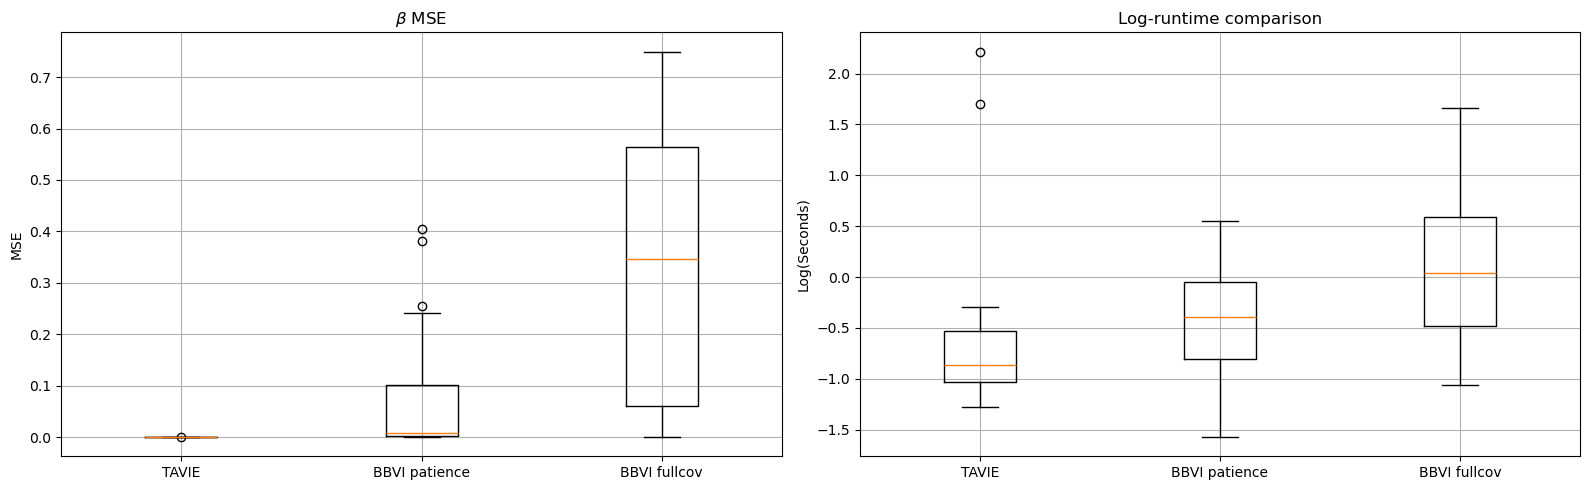

In [4]:
# Plotting results for TAVIE and BBVI
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Beta MSE comparison
axes[0].boxplot([mse_beta_TAVIE, mse_beta_BBVI, mse_beta_BBVI_fullcov], tick_labels=['TAVIE', 'BBVI patience', 'BBVI fullcov'])
axes[0].set_title(r'$\beta$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_BBVI), np.log(time_BBVI_fullcov)], 
                tick_labels=['TAVIE', 'BBVI patience', 'BBVI fullcov'])
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
plt.show()